In [1]:
%load_ext xsimlab.ipython
import numpy as np
import xsimlab as xs
import xarray as xr
import matplotlib.pyplot as plt
import zarr
import pandas as pd
import matplotlib.colors as mcolors
from scipy.stats import gmean
import sys
import os

In [2]:
def find_closest(arr, val):
       idx = np.abs(arr - val).argmin()
       return arr[idx]

In [3]:
%config InlineBackend.figure_format = 'svg'

## Part 1) Import the data

In [4]:
#
ERMeasured=0.000065
ERerror=0.00002
MoonLightBaseLevel=200 #Approximate baselevel at river
BackthrustBaseLevel=325
MeanBaselevel=(MoonLightBaseLevel+BackthrustBaseLevel)/2
FanMeasured=723#-MeanBaselevel
FanError=200
MeanMountainHeight=1408
MaxMountainHeight=2665
MaxOrogenError=400

In [5]:
print(os.getcwd())

/Users/amandawild/Desktop/ClimateSignalPropagation_AlluvialFanGrainSize/Part2_GrapevineMountains/BestFit_Grapevine


In [6]:
#Run only once
os.chdir('..')
os.chdir('..')
os.chdir('Data_Darcyetal2017')
print(os.getcwd())

/Users/amandawild/Desktop/ClimateSignalPropagation_AlluvialFanGrainSize/Data_Darcyetal2017


In [7]:
#Data RElated
Moonlight = pd.read_csv('Moonlight_holoQ2.csv')
BackThrust = pd.read_csv('Backthrust_holoQ2.csv')
#
AvgApexGS=(BackThrust.MEAND.max()+BackThrust.Q2MEAND.max()+Moonlight.MEAND.max()+Moonlight.Q2MEAND.max())/4
AvgD0=AvgApexGS#25.75 #first values

In [8]:
# Compute all Necessary Data Misfit Values
#1) Slope
#Remove Nans
FanLong=np.array([0,1,2,3,4,5,6])
MoonlightDistance=Moonlight.Distance.dropna(inplace = False)
MoonlightElevation=Moonlight.Elevation.dropna(inplace = False)
MoonlightQ2Distance=Moonlight.Q2Distance.dropna(inplace = False)
MoonlightQ2Elevation=Moonlight.Q2Elevation.dropna(inplace = False)
BackthrustDistance=BackThrust.Distance.dropna(inplace = False)
BackthrustElevation=BackThrust.Elevation.dropna(inplace = False)
BackthrustQ2Distance=BackThrust.Q2Distance.dropna(inplace = False)
BackthrustQ2Elevation=BackThrust.Q2Elevation.dropna(inplace = False)
#
#Derive the profile Slope
BackThrustSlope=(BackthrustElevation[0]-BackthrustElevation[len(BackthrustElevation)-1])/(BackthrustDistance[len(BackthrustDistance)-1]*1000)
BackThrustQ2Slope=(BackthrustQ2Elevation[0]-BackthrustQ2Elevation[len(BackthrustQ2Elevation)-1])/(BackthrustQ2Distance[len(BackthrustQ2Distance)-1]*1000)
MoonlightSlope=(MoonlightElevation[0]-MoonlightElevation[len(MoonlightElevation)-1])/(MoonlightDistance[len(MoonlightDistance)-1]*1000)
MoonlightQ2Slope=(MoonlightQ2Elevation[0]-MoonlightQ2Elevation[len(MoonlightQ2Elevation)-1])/(MoonlightQ2Distance[len(MoonlightQ2Distance)-1]*1000)
MaxSlopeError=np.max([BackThrustSlope,BackThrustQ2Slope,MoonlightSlope,MoonlightQ2Slope])-np.min([BackThrustSlope,BackThrustQ2Slope,MoonlightSlope,MoonlightQ2Slope])
MeanFANSlope=np.nanmean([BackThrustSlope,BackThrustQ2Slope,MoonlightSlope,MoonlightQ2Slope])
#
#2) Elevation and D50
MoonlightElevation_Misfit=np.zeros(len(FanLong))
MoonlightD50_Misfit=np.zeros(len(FanLong))
MoonlightQ2Elevation_Misfit=np.zeros(len(FanLong))
MoonlightQ2D50_Misfit=np.zeros(len(FanLong))
BackthrustElevation_Misfit=np.zeros(len(FanLong))
BackthrustD50_Misfit=np.zeros(len(FanLong))
BackthrustQ2Elevation_Misfit=np.zeros(len(FanLong))
BackthrustQ2D50_Misfit=np.zeros(len(FanLong))
#
for i in range(len(FanLong)):
    temp=int(np. where(MoonlightDistance == (find_closest(MoonlightDistance, FanLong[i])))[0])
    MoonlightElevation_Misfit[i]=Moonlight.Elevation[temp]
    MoonlightD50_Misfit[i]=Moonlight.MEAND[temp]
    #
    temp=int(np. where(MoonlightQ2Distance == (find_closest(MoonlightQ2Distance, FanLong[i])))[0])
    MoonlightQ2Elevation_Misfit[i]=Moonlight.Q2Elevation[temp]
    MoonlightQ2D50_Misfit[i]=Moonlight.Q2MEAND[temp]
    #
    temp=int(np. where(BackThrust.Distance == (find_closest(BackThrust.Distance, FanLong[i])))[0])
    BackthrustElevation_Misfit[i]=BackThrust.Elevation[temp]
    BackthrustD50_Misfit[i]=BackThrust.MEAND[temp]
    #
    temp=int(np. where(BackThrust.Q2Distance == (find_closest(BackThrust.Q2Distance, FanLong[i])))[0])
    BackthrustQ2Elevation_Misfit[i]=BackThrust.Q2Elevation[temp]
    BackthrustQ2D50_Misfit[i]=BackThrust.Q2MEAND[temp]
#Final GS and Elevation
MoonlightElevation_Misfit=MoonlightElevation_Misfit-MoonLightBaseLevel
MoonlightQ2Elevation_Misfit=MoonlightQ2Elevation_Misfit-MoonLightBaseLevel
BackthrustElevation_Misfit=BackthrustElevation_Misfit-BackthrustBaseLevel
BackthrustQ2Elevation_Misfit=BackthrustQ2Elevation_Misfit-BackthrustBaseLevel
AvgFanD50_Misfit=(MoonlightD50_Misfit+MoonlightQ2D50_Misfit+BackthrustQ2D50_Misfit+BackthrustD50_Misfit)/4
AvgFanElevation_Misfit=(MoonlightElevation_Misfit+MoonlightQ2Elevation_Misfit+BackthrustQ2Elevation_Misfit+BackthrustElevation_Misfit)/4
#Error
minFanGS=np.zeros(len(FanLong))
maxFanGS=np.zeros(len(FanLong))
minFanEL=np.zeros(len(FanLong))
maxFanEL=np.zeros(len(FanLong))
for i in range (len(FanLong)):
    minFanGS[i]=np.min([MoonlightD50_Misfit[i],MoonlightQ2D50_Misfit[i],BackthrustD50_Misfit[i],BackthrustQ2D50_Misfit[i]])
    maxFanGS[i]=np.max([MoonlightD50_Misfit[i],MoonlightQ2D50_Misfit[i],BackthrustD50_Misfit[i],BackthrustQ2D50_Misfit[i]])
    minFanEL[i]=np.min([MoonlightElevation_Misfit[i],MoonlightQ2Elevation_Misfit[i],BackthrustElevation_Misfit[i],BackthrustQ2Elevation_Misfit[i]])
    maxFanEL[i]=np.max([MoonlightElevation_Misfit[i],MoonlightQ2Elevation_Misfit[i],BackthrustElevation_Misfit[i],BackthrustQ2Elevation_Misfit[i]])
DiffEL=maxFanEL-minFanEL
ErrorELMisfit=np.nanmean(DiffEL)
DiffGS=maxFanGS-minFanGS
ErrorGSMisfit=np.nanmean(DiffGS)
#import data

#print(zdatasetG2p75_alpha2_S0p0001.out.isel(out=OutB4Precip).values)
#print(zdatasetG2p75_alpha2_S0p0001.out.isel(out=1).values*AveragingTimeSteps)

/var/folders/3s/tcks83w145s7qy4fms3rt2jw0000gn/T/ipykernel_47377/1502415183.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  temp=int(np. where(MoonlightDistance == (find_closest(MoonlightDistance, FanLong[i])))[0])
/var/folders/3s/tcks83w145s7qy4fms3rt2jw0000gn/T/ipykernel_47377/1502415183.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  temp=int(np. where(MoonlightQ2Distance == (find_closest(MoonlightQ2Distance, FanLong[i])))[0])
/var/folders/3s/tcks83w145s7qy4fms3rt2jw0000gn/T/ipykernel_47377/1502415183.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure yo

## Part 2) Add or run the best fit model with oscillations after 17Myrs

In [9]:
### In this case we import the model that has already been run in FastScape

In [10]:
os.chdir('..')
os.chdir('Part2_GrapevineMountains/BestFit_Grapevine')
print(os.getcwd())

/Users/amandawild/Desktop/ClimateSignalPropagation_AlluvialFanGrainSize/Part2_GrapevineMountains/BestFit_Grapevine


In [11]:
#Real World Data
MeanFanorCatchmentWidth=2e3#2.5e3 #meters
NumberofFansorCatchments=2#2.8
wm = 17e3 # width of the mountain (in m)
wb = 0.1e3 #7e3# with of the basin (in m)
CellSize=100 #Width of larger channels #m 

In [12]:
zdataset = xr.open_zarr('G2p75Best_100kyrOscillationslong.zarr').set_index().isel(out=slice(0,884)).isel(time=slice(0,1768)) 
zdataset.x.attrs["units"] = "m"
zdataset.y.attrs["units"] = "m"
zdataset.out.attrs["units"] = "years"

startbasin=int(wm/CellSize)
endbasin=-1
aspects= 1#If 2, x direction will be twice as long as y. #xl/yl
sizes= 8

In [13]:
PrecipOsc_OUT_ONSET=850
PrecipOsc_TIME_ONSET=PrecipOsc_OUT_ONSET*2
SevenHundredKyr_B4after_OUT=34
SevenHundredKyr_B4after_TIME=SevenHundredKyr_B4after_OUT*2
SpatialAvg_100m=2

## Part 3) Plot the avg. data after 17Myrs before adding the precipitation oscillations

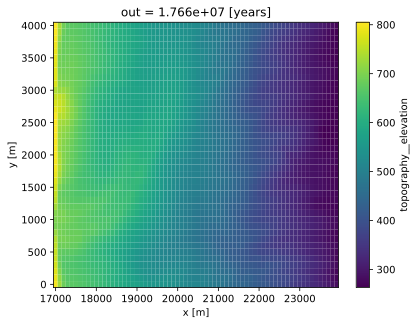

In [14]:
#fan topography
zdataset.topography__elevation.isel(out=-1).isel(x=slice(170,-1)).plot()

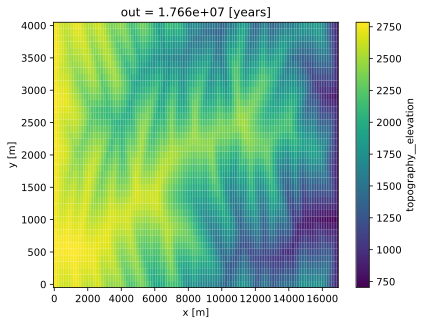

In [15]:
#orogen topography
zdataset.topography__elevation.isel(out=-1).isel(x=slice(0,170)).plot()

In [16]:
FanDistance=(zdataset.x.isel(x=slice(startbasin,250))-17000)/1000

In [17]:
#simulation Specifics
startfan=170
startbasin=170
endfan=272
endbasin=272
OutB4Precip=850
AveragingTimeSteps=20 #500000yrs
zdatasetG2p75_alpha2_S0p000075 = xr.open_zarr('G2p75Best_100kyrOscillationslong.zarr')
#zdatasetG2p75_alpha2_S0p000075 = xr.open_zarr('G2p75Experimentalpha2p5_0p0001subsidenceks0p25.zarr')
#Select Large Channel Areas using Geometric Mean
FinalTimeGmeanQ=gmean(zdatasetG2p75_alpha2_S0p000075.drainage__flowacc.isel(x=slice(startbasin,endbasin)).isel(out=slice(OutB4Precip-AveragingTimeSteps,OutB4Precip)).mean('out').mean('y')) 
BinaryQ=xr.DataArray(np.where(zdatasetG2p75_alpha2_S0p000075.drainage__flowacc.isel(x=slice(startbasin,endbasin)).isel(out=slice(OutB4Precip-AveragingTimeSteps,OutB4Precip))>=FinalTimeGmeanQ,1,0),dims=['out','y','x'])
LargeQDrainageG2p75_alpha2_S0p000075=xr.DataArray(np.where(BinaryQ==1,zdatasetG2p75_alpha2_S0p000075.drainage__flowacc.isel(x=slice(startbasin,endbasin)).isel(out=slice(OutB4Precip-AveragingTimeSteps,OutB4Precip)),np.nan),dims=['out','y','x'])
Topo_LargeChannelsG2p75_alpha2_S0p000075=xr.DataArray(np.where(BinaryQ==1,zdatasetG2p75_alpha2_S0p000075.topography__elevation.isel(x=slice(startbasin,endbasin)).isel(out=slice(OutB4Precip-AveragingTimeSteps,OutB4Precip)),np.nan),dims=['out','y','x'])
GS_LargeChannelsG2p75_alpha2_S0p000075=xr.DataArray(np.where(BinaryQ==1,zdatasetG2p75_alpha2_S0p000075.gsize__DMean.isel(x=slice(startbasin,endbasin)).isel(out=slice(OutB4Precip-AveragingTimeSteps,OutB4Precip)),np.nan),dims=['out','y','x'])
# Select largest channel
GS_LargestChannelG2p75_alpha2_S0p000075=xr.DataArray(np.where(zdatasetG2p75_alpha2_S0p000075.drainage__flowacc.isel(x=slice(startbasin,endbasin)).isel(out=slice(OutB4Precip-AveragingTimeSteps,OutB4Precip))==
                           zdatasetG2p75_alpha2_S0p000075.drainage__flowacc.isel(x=slice(startbasin,endbasin)).isel(out=slice(OutB4Precip-AveragingTimeSteps,OutB4Precip)).max('y'),
         zdatasetG2p75_alpha2_S0p000075.gsize__DMean.isel(x=slice(startbasin,endbasin)).isel(out=slice(OutB4Precip-AveragingTimeSteps,OutB4Precip)),np.nan),dims=['out','y','x'])
#
LargestChannelG2p75_alpha2_S0p000075=xr.DataArray(np.where(zdatasetG2p75_alpha2_S0p000075.drainage__flowacc.isel(x=slice(startbasin,endbasin)).isel(out=slice(OutB4Precip-AveragingTimeSteps,OutB4Precip))==
                           zdatasetG2p75_alpha2_S0p000075.drainage__flowacc.isel(x=slice(startbasin,endbasin)).isel(out=slice(OutB4Precip-AveragingTimeSteps,OutB4Precip)).max('y'),
         zdatasetG2p75_alpha2_S0p000075.drainage__flowacc.isel(x=slice(startbasin,endbasin)).isel(out=slice(OutB4Precip-AveragingTimeSteps,OutB4Precip)),np.nan),dims=['out','y','x'])
#
Topo_LargestChannelG2p75_alpha2_S0p000075=xr.DataArray(np.where(zdatasetG2p75_alpha2_S0p000075.drainage__flowacc.isel(x=slice(startbasin,endbasin)).isel(out=slice(OutB4Precip-AveragingTimeSteps,OutB4Precip))==
                           zdatasetG2p75_alpha2_S0p000075.drainage__flowacc.isel(x=slice(startbasin,endbasin)).isel(out=slice(OutB4Precip-AveragingTimeSteps,OutB4Precip)).max('y'),
         zdatasetG2p75_alpha2_S0p000075.topography__elevation.isel(x=slice(startbasin,endbasin)).isel(out=slice(OutB4Precip-AveragingTimeSteps,OutB4Precip)),np.nan),dims=['out','y','x'])
#Select all channels 
GS_AllchannelsG2p75_alpha2_S0p000075=zdatasetG2p75_alpha2_S0p000075.gsize__DMean.isel(x=slice(startbasin,endbasin)).isel(out=slice(OutB4Precip-AveragingTimeSteps,OutB4Precip))
Topo_AllchannelsG2p75_alpha2_S0p000075=zdatasetG2p75_alpha2_S0p000075.topography__elevation.isel(x=slice(startbasin,endbasin)).isel(out=slice(OutB4Precip-AveragingTimeSteps,OutB4Precip))
QAllchannelsG2p75_alpha2_S0p000075=zdatasetG2p75_alpha2_S0p000075.drainage__flowacc.isel(x=slice(startbasin,endbasin)).isel(out=slice(OutB4Precip-AveragingTimeSteps,OutB4Precip))

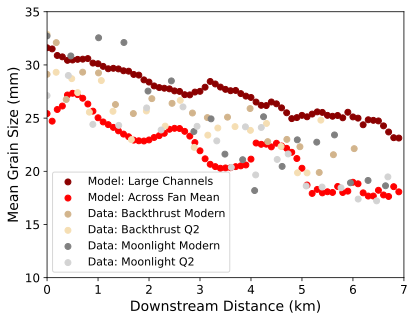

In [18]:
import matplotlib.pyplot as plt

# Plot data
#plt.scatter(FanDistance, GS_LargestChannelG2p75_alpha2_S0p000075.mean('out').mean('y') * AvgApexGS, color='k')
plt.scatter(FanDistance, GS_LargeChannelsG2p75_alpha2_S0p000075.mean('out').mean('y') * AvgApexGS, color='darkred')
plt.scatter(FanDistance, GS_AllchannelsG2p75_alpha2_S0p000075.mean('out').mean('y') * AvgApexGS, color='red')

# Additional scatter data

c = plt.scatter(Moonlight.Distance, Moonlight.MEAND, color='tan')
d = plt.scatter(Moonlight.Q2Distance, Moonlight.Q2MEAND, color='wheat')
a = plt.scatter(BackThrust.Distance, BackThrust.MEAND, color='grey')
b = plt.scatter(BackThrust.Q2Distance, BackThrust.Q2MEAND, color='lightgrey')

# Set axis limits
plt.ylim(10, 35)
plt.xlim(0, 7)

# Set axis labels with larger font size
plt.ylabel('Mean Grain Size (mm)', color='k', fontsize=14)
plt.xlabel('Downstream Distance (km)', color='k', fontsize=14)

# Increase the size of the tick labels on both axes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add legend with larger font size
plt.legend(['Model: Large Channels', 'Model: Across Fan Mean', 'Data: Backthrust Modern', 'Data: Backthrust Q2', 'Data: Moonlight Modern', 'Data: Moonlight Q2'], fontsize=11)

# Optionally, if you want to save the plot
#plt.savefig('BEST_GS_mOdelData.pdf', bbox_inches="tight")

plt.show()


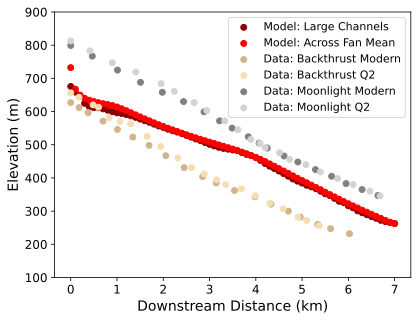

In [19]:
import matplotlib.pyplot as plt

# Scatter plot data
plt.scatter(FanDistance, Topo_LargeChannelsG2p75_alpha2_S0p000075.mean('out').mean('y'), color='darkred')
plt.scatter(FanDistance, Topo_AllchannelsG2p75_alpha2_S0p000075.mean('out').mean('y'), color='red')

# Additional scatter data

plt.scatter(Moonlight.Distance, Moonlight.Elevation, color='tan')
plt.scatter(Moonlight.Q2Distance, Moonlight.Q2Elevation, color='wheat')
plt.scatter(BackThrust.Distance, BackThrust.Elevation, color='grey')
plt.scatter(BackThrust.Q2Distance, BackThrust.Q2Elevation, color='lightgrey')

# Set axis labels with larger font size
plt.xlabel('Downstream Distance (km)', fontsize=14)
plt.ylabel('Elevation (m)', fontsize=14)

# Increase the size of the tick labels on both axes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Set y-axis limits
plt.ylim(100, 900)

# Add legend with larger font size
plt.legend(['Model: Large Channels', 'Model: Across Fan Mean', 'Data: Backthrust Modern', 'Data: Backthrust Q2', 'Data: Moonlight Modern', 'Data: Moonlight Q2'], fontsize=11)

# Optionally, if you want to save the plot
plt.savefig('BEST_Topo_ModelData.pdf', bbox_inches="tight")

plt.show()


## Part 4) add the precipitation oscillations

In [20]:
# End of Fan

In [21]:
max_drainage_indices = xr.DataArray(zdataset.drainage__flowacc.argmax('y')).load()
GS_LargestChannel=(zdataset.gsize__DMean.sel(y=zdataset.y[max_drainage_indices]))
ER_LargestChannel=(zdataset.erosion__rate.sel(y=zdataset.y[max_drainage_indices]))
Topo_LargestChannel=(zdataset.topography__elevation.sel(y=zdataset.y[max_drainage_indices]))
#Largest Channel
#End_LargestChannelGS=GS_LargestChannel.isel(x=slice(-SpatialAvg_100m,-1)).mean('x').isel(out=slice(PrecipOsc_OUT_ONSET-SevenHundredKyr_B4after_OUT,PrecipOsc_OUT_ONSET+SevenHundredKyr_B4after_OUT))

In [22]:
SpatialAvg_100m=70

In [23]:
#Average Across the whole fan

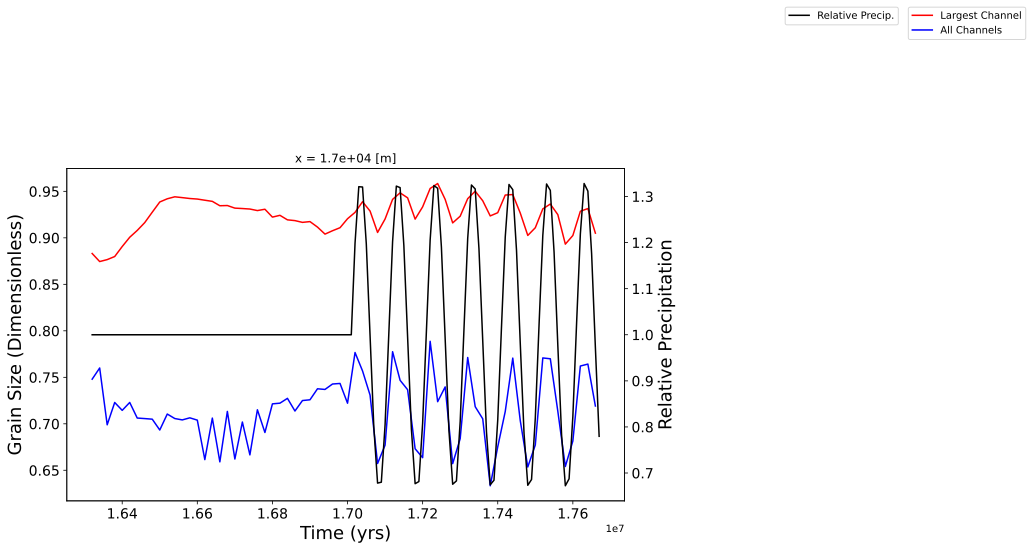

In [24]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot for Largest Channel (End)
End_LargestChannelGS = GS_LargestChannel.isel(x=slice(-SpatialAvg_100m, -1)).mean('x').isel(out=slice(PrecipOsc_OUT_ONSET-SevenHundredKyr_B4after_OUT, PrecipOsc_OUT_ONSET+SevenHundredKyr_B4after_OUT)).plot(color='r', label='Largest Channel' )

# Plot for All Channels (End)
zdataset.gsize__DMean.mean('y').isel(x=slice(-SpatialAvg_100m, -1)).mean('x').isel(out=slice(PrecipOsc_OUT_ONSET-SevenHundredKyr_B4after_OUT, PrecipOsc_OUT_ONSET+SevenHundredKyr_B4after_OUT)).plot(color='b', label='All Channels' )

# Adding legend to the first axis
ax1.legend(loc='upper left', bbox_to_anchor=(1.5, 1.5)) 

# Secondary axis
ax2 = ax1.twinx()
(zdataset.drainage__runoff.mean('y').isel(x=startbasin).isel(time=slice(PrecipOsc_TIME_ONSET-SevenHundredKyr_B4after_TIME, PrecipOsc_TIME_ONSET+SevenHundredKyr_B4after_TIME))).plot(color='k', label='Relative Precip.')


# Add labels and increase their font size
ax1.set_xlabel('Time (yrs)', color='k', fontsize=18)  # Adjust fontsize as needed
ax1.set_ylabel('Grain Size (Dimensionless)', color='k', fontsize=18)  # Adjust fontsize as needed
ax2.set_ylabel('Relative Precipitation', color='k', fontsize=18)  # Adjust fontsize as needed

# Change the color and size of the ticks and tick labels
ax1.tick_params(axis='x', colors='k', labelsize=14)  # Increase tick label size
ax1.tick_params(axis='y', colors='k', labelsize=14)  # Increase tick label size
ax2.tick_params(axis='y', colors='k', labelsize=14)  # Increase tick label size


# Adding legend to the second axis
ax2.legend(loc='upper right', bbox_to_anchor=(1.5, 1.5)) 
plt.savefig('GS_Average.pdf', format='pdf', bbox_inches='tight')
plt.show()

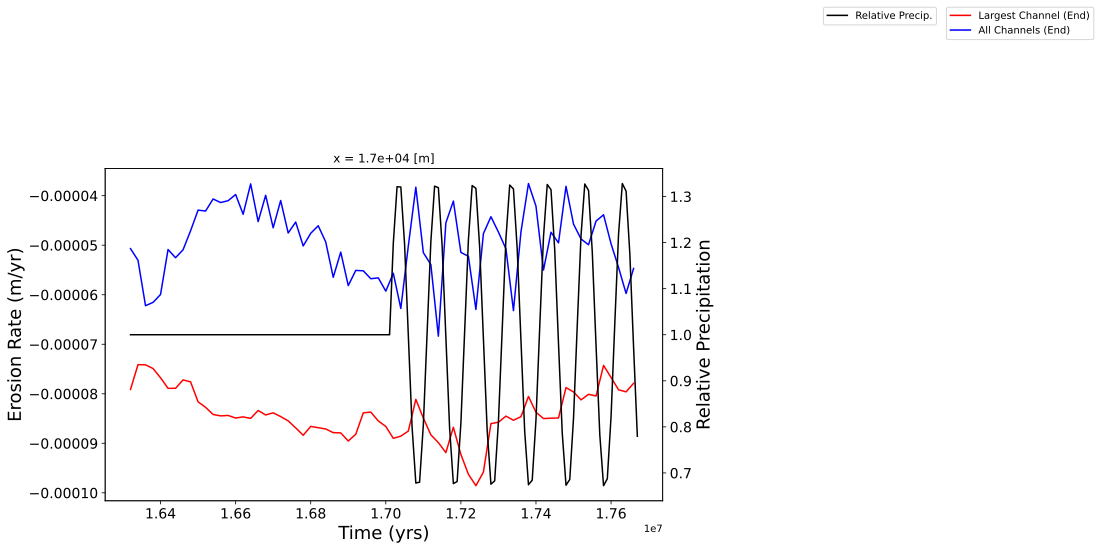

In [25]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot for Largest Channel (End)
End_LargestChannelGS = ER_LargestChannel.isel(x=slice(-SpatialAvg_100m, -1)).mean('x').isel(out=slice(PrecipOsc_OUT_ONSET-SevenHundredKyr_B4after_OUT, PrecipOsc_OUT_ONSET+SevenHundredKyr_B4after_OUT)).plot(color='r', label='Largest Channel (End)' )

# Plot for All Channels (End)
zdataset.erosion__rate.mean('y').isel(x=slice(-SpatialAvg_100m, -1)).mean('x').isel(out=slice(PrecipOsc_OUT_ONSET-SevenHundredKyr_B4after_OUT, PrecipOsc_OUT_ONSET+SevenHundredKyr_B4after_OUT)).plot(color='b', label='All Channels (End)' )

# Adding legend to the first axis
ax1.legend(loc='upper left', bbox_to_anchor=(1.5, 1.5)) 

# Secondary axis
ax2 = ax1.twinx()
(zdataset.drainage__runoff.mean('y').isel(x=startbasin).isel(time=slice(PrecipOsc_TIME_ONSET-SevenHundredKyr_B4after_TIME, PrecipOsc_TIME_ONSET+SevenHundredKyr_B4after_TIME))).plot(color='k', label='Relative Precip.')


# Add labels and increase their font size
ax1.set_xlabel('Time (yrs)', color='k', fontsize=18)  # Adjust fontsize as needed
ax1.set_ylabel('Erosion Rate (m/yr)', color='k', fontsize=18)  # Adjust fontsize as needed
ax2.set_ylabel('Relative Precipitation', color='k', fontsize=18)  # Adjust fontsize as needed

# Change the color and size of the ticks and tick labels
ax1.tick_params(axis='x', colors='k', labelsize=14)  # Increase tick label size
ax1.tick_params(axis='y', colors='k', labelsize=14)  # Increase tick label size
ax2.tick_params(axis='y', colors='k', labelsize=14)  # Increase tick label size


# Adding legend to the second axis
ax2.legend(loc='upper right', bbox_to_anchor=(1.5, 1.5)) 
plt.savefig('ERAvg.pdf', format='pdf', bbox_inches='tight')
plt.show()

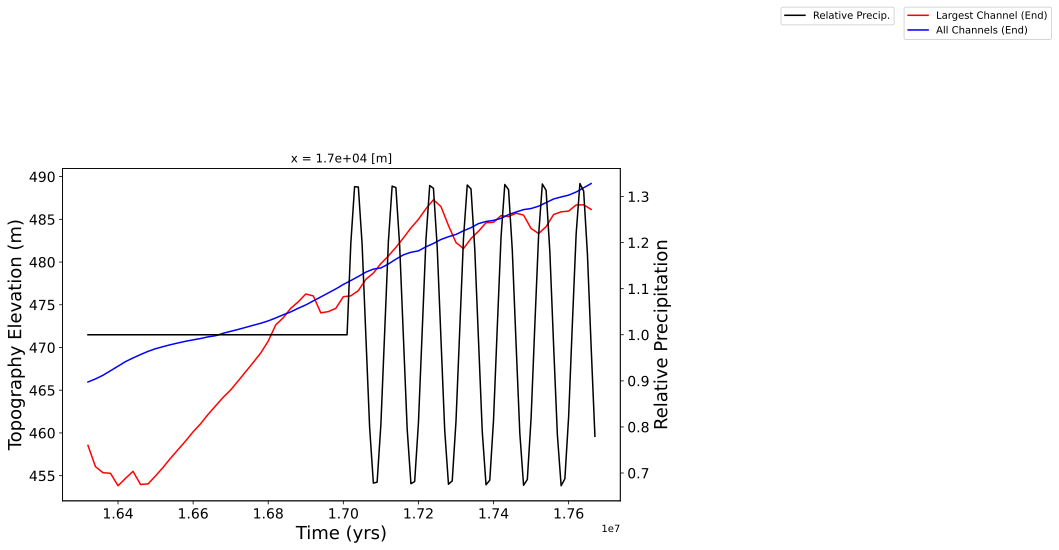

In [26]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot for Largest Channel (End)
End_LargestChannelGS = Topo_LargestChannel.isel(x=slice(-SpatialAvg_100m, -1)).mean('x').isel(out=slice(PrecipOsc_OUT_ONSET-SevenHundredKyr_B4after_OUT, PrecipOsc_OUT_ONSET+SevenHundredKyr_B4after_OUT)).plot(color='r', label='Largest Channel (End)' )

# Plot for All Channels (End)
zdataset.topography__elevation.mean('y').isel(x=slice(-SpatialAvg_100m, -1)).mean('x').isel(out=slice(PrecipOsc_OUT_ONSET-SevenHundredKyr_B4after_OUT, PrecipOsc_OUT_ONSET+SevenHundredKyr_B4after_OUT)).plot(color='b', label='All Channels (End)' )

# Adding legend to the first axis
ax1.legend(loc='upper left', bbox_to_anchor=(1.5, 1.5)) 

# Secondary axis
ax2 = ax1.twinx()
(zdataset.drainage__runoff.mean('y').isel(x=startbasin).isel(time=slice(PrecipOsc_TIME_ONSET-SevenHundredKyr_B4after_TIME, PrecipOsc_TIME_ONSET+SevenHundredKyr_B4after_TIME))).plot(color='k', label='Relative Precip.')


# Add labels and increase their font size
ax1.set_xlabel('Time (yrs)', color='k', fontsize=18)  # Adjust fontsize as needed
ax1.set_ylabel('Topography Elevation (m)', color='k', fontsize=18)  # Adjust fontsize as needed
ax2.set_ylabel('Relative Precipitation', color='k', fontsize=18)  # Adjust fontsize as needed

# Change the color and size of the ticks and tick labels
ax1.tick_params(axis='x', colors='k', labelsize=14)  # Increase tick label size
ax1.tick_params(axis='y', colors='k', labelsize=14)  # Increase tick label size
ax2.tick_params(axis='y', colors='k', labelsize=14)  # Increase tick label size


# Adding legend to the second axis
ax2.legend(loc='upper right', bbox_to_anchor=(1.5, 1.5)) 
plt.savefig('TopoAvg.pdf', format='pdf', bbox_inches='tight')
plt.show()